# Bayesian Optimization of Combinatorial Structures

Reference: https://altema.is.tohoku.ac.jp/QA4U/

## Black-Box function

In [1]:
import numpy as np
import dimod

class QUBOBlackBox:
    def __init__(self, num_variables):
        qubo = np.random.normal(size=(num_variables, num_variables))
        self.bqm = dimod.BQM(qubo, 'BINARY')

    def __call__(self, x):
        if len(np.array(x).shape) == 1:
            return self.bqm.energy(x)
        else:
            return self.bqm.energies(x)

class PolyBlackBox:
    def __init__(self, num_variables, degrees=3):
        poly = {key: np.random.normal()
                for key in combinations(range(num_variables), degrees)}
        self.bpm = dimod.BinaryPolynomial(poly, 'BINARY')

    def __call__(self, x):
        if len(np.array(x).shape) == 1:
            return self.bpm.energy(x)
        else:
            return self.bpm.energies(x)

def my_black_box(x):
    energy = 0
    return energy

In [2]:
from itertools import combinations

num_variables = 16
blackbox = QUBOBlackBox(num_variables)
# blackbox = PolyBlackBox(num_variables)
# blackbox = my_black_box

## Initial data

In [3]:
def quadratic_feature(x):
    num_variables = len(x)
    features = [1] + list(x)
    for k in range(num_variables - 1):
        for l in range(k + 1, num_variables):
            features.append(x[k] * x[l])
    return np.array(features)

def generate_init_data(blackbox, num_variables, num_init_data):
    X_init, y_init = [], []
    for k in range(num_init_data):
        x = np.random.choice([0, 1], num_variables)
        y = blackbox(x)
        X_init.append(quadratic_feature(x))
        y_init.append(y)
    return np.array(X_init), np.array(y_init)

In [4]:
X, y = generate_init_data(blackbox, num_variables, num_init_data=5)

## Acquisition function with QUBO

In [5]:
def acquisitions_to_bqm(acquisitions, num_variables):
    qubo = np.diag(acquisitions[1: num_variables + 1])  # 0: const
    n = 0
    for k in range(num_variables - 1):
        for l in range(k + 1, num_variables):
            qubo[k, l] = acquisitions[num_variables + 1 + n]
            n += 1
    return dimod.BQM(qubo, 'BINARY')

def fit_acquisitions(X, y, lam=0.01):
    XX_lamI_inv = np.linalg.inv(np.dot(X.T, X) + lam * np.eye(X.shape[1]))
    avg = np.dot(XX_lamI_inv, np.dot(X.T, y))
    var = 0.5 * XX_lamI_inv
    return np.random.multivariate_normal(avg, var)

## Search by annealing

In [6]:
from neal import SimulatedAnnealingSampler
from tqdm import tqdm

sampler = SimulatedAnnealingSampler()
sampling_params = dict(num_reads=10, num_sweeps=1000)

y_min_hists = []
energy_mean_hists = []
similarity_hists = []  # only QUBOBlackBox

num_iters = 200
for _ in tqdm(np.arange(num_iters)):
    acquisitions = fit_acquisitions(X, y)
    bqm = acquisitions_to_bqm(acquisitions, num_variables)
    sampleset = sampler.sample(bqm, **sampling_params)
    x_new = sampleset.lowest().record[0].sample
    y_new = blackbox(x_new)

    y_min_hists.append(min(y_new, np.min(y)))
    X = np.vstack([X, quadratic_feature(x_new)])
    y = np.append(y, y_new)

    energy_mean = np.mean((bqm.energies(X[:, 1: num_variables + 1]) - blackbox(X[:, 1: num_variables + 1]))**2)
    energy_mean_hists.append(energy_mean)

    # only QUBOBlackBox
    similarity = np.sum((bqm.to_numpy_matrix() - blackbox.bqm.to_numpy_matrix())**2) / X.shape[1]
    similarity_hists.append(similarity)

100%|██████████| 200/200 [00:02<00:00, 77.19it/s]


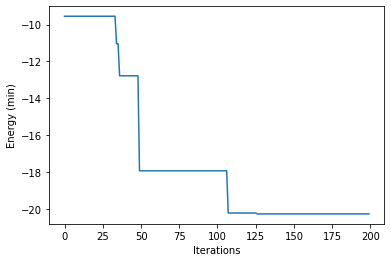

In [7]:
import matplotlib.pyplot as plt

plt.plot(y_min_hists)
plt.xlabel('Iterations')
plt.ylabel('Energy (min)')
plt.show()

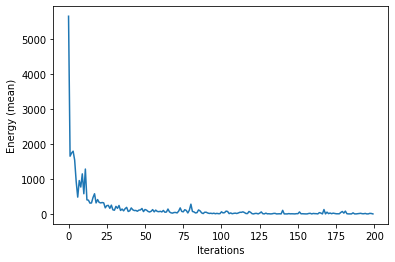

In [8]:
plt.plot(energy_mean_hists)
plt.xlabel('Iterations')
plt.ylabel('Energy (mean)')
plt.show()

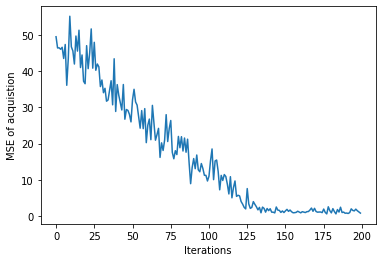

In [9]:
plt.plot(similarity_hists)
plt.xlabel('Iterations')
plt.ylabel('MSE of acquistion')
plt.show()

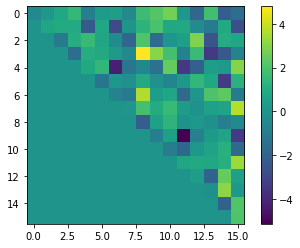

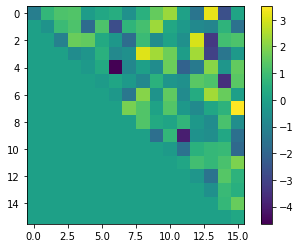

In [10]:
plt.imshow(bqm.to_numpy_matrix().astype(float))
plt.colorbar()
plt.show()

plt.imshow(blackbox.bqm.to_numpy_matrix().astype(float))
plt.colorbar()
plt.show()